# Himawari download and plot code (Claude.ai credit)

Timespan Start: 2024/11/03 12:00 - 2024/11/15 16:40 from [CIRA loop here](https://satlib.cira.colostate.edu/weather_media/parade-of-typhoons-in-the-western-pacific/) , the first 4-active-typhoon scene in recorded history occurs on [Nov 11 00Z](https://en.wikipedia.org/wiki/Typhoon_Man-yi#/media/File:Yinxing,_Toraji,_Usagi,_and_Man-yi_2024-11-11_0000Z.jpg), Man-Yi hit Plillippines and dissipated Nov 20. 

In [1]:
"""
Himawari-9 Band 13 Data Visualization
Downloads and processes AHI-L1b-FLDK data from AWS S3
"""

# Install required packages (run once)
# !pip install satpy[all] s3fs matplotlib numpy cartopy

import s3fs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgba
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from satpy import Scene
from datetime import datetime, timedelta
import tempfile
import os
from pathlib import Path

# suppress a warning in output 
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in log")


# Configuration
START_DATE = datetime(2024, 11, 3, 12, 0)
END_DATE = datetime(2024, 11, 20, 0, 0)  # Adjust as needed, full length here, just keep restarting! 
TIME_INTERVAL = 10  # minutes
BAND = 13
SEGMENTS = range(1, 7)  # Segments 1-6 is 1,7
TOTAL_SEGMENTS = 10
RESOLUTION = "R20"
OUTPUT_DIR = "/Volumes/SamsungUSB/Himawari_parade"

# Custom colormap with transparency
color_points = [
    (190, "#dc05ef", 1.0),  # magenta 
    (222, "#0589ef", 1.0),  # blue
    (240, "#00ffff", 1.0),  # cyan
    (250, "#716f6f", 1.0),  # darker gray 
    (270, "#c5c6c6", 1.0),  # light-mid gray
    (280, "#ffffff", 0.7),  # white semitrans
    (290, "#ffffff", 0.3),  # white point surface
    (300, "#ffffff", 0.1),  # SST point water
    (305, "#ffffff", 0.3),  # white 
    (310, "#ff8000", 0.6),  # hot orange
    (340, "#000000", 0.8)   # very hot black
]
vmin, vmax = 190, 340
custom_cmap = LinearSegmentedColormap.from_list("custom", [
    ((v - vmin) / (vmax - vmin), to_rgba(c, a)) for v, c, a in color_points
])

def generate_urls(dt):
    """Generate S3 URLs for all segments at given datetime"""
    base = f"AHI-L1b-FLDK/{dt:%Y/%m/%d/%H%M}"
    return [
        f"noaa-himawari9/{base}/HS_H09_{dt:%Y%m%d_%H%M}_B{BAND:02d}_FLDK_{RESOLUTION}_S{seg:02d}{TOTAL_SEGMENTS}.DAT.bz2"
        for seg in SEGMENTS
    ]

def get_output_filename(dt, output_dir):
    """Generate output filename for a given datetime"""
    return f"{output_dir}/himawari9_b{BAND:02d}_{dt:%Y%m%d_%H%M}.png"

def already_exists(dt, output_dir):
    """Check if output file already exists"""
    return os.path.exists(get_output_filename(dt, output_dir))

def download_and_plot(dt, output_dir):
    """Download segments and create composite image"""
    fs = s3fs.S3FileSystem(anon=True)
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    with tempfile.TemporaryDirectory() as tmpdir:
        local_files = []
        urls = generate_urls(dt)
        
        # Download segments
        errors = []
        for url in urls:
            try:
                local_path = f"{tmpdir}/{Path(url).name}"
                fs.get(url, local_path)
                local_files.append(local_path)
            except Exception as e:
                errors.append(str(e))
        
        # Need at least some segments
        if len(local_files) < 3:
            return None
        
        # Read with satpy
        scn = Scene(reader='ahi_hsd', filenames=local_files)
        scn.load([f'B{BAND:02d}'])


        # Get the coordinate reference system
        dataset_key = f'B{BAND:02d}'
        crs = scn[dataset_key].attrs['area'].to_cartopy_crs()
        
        plt.figure(figsize=(16, 16), dpi=150)  # Larger size, higher resolution
        
        ax = plt.axes(projection=crs)
        ax.set_facecolor('black')
        ax.add_feature(cfeature.OCEAN, facecolor='black')
        ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#587A4E')  
        
        # Add background (e.g., natural Earth or stock image) -- CRASHES 
        # ax.stock_img()  # or ax.add_image(...) with specific tiles
        
        # Overlay satellite data
        ax.imshow(scn[dataset_key], transform=crs, cmap=custom_cmap, vmin=vmin, vmax=vmax, \
                  extent=crs.bounds, origin='upper', zorder=5)
        
        # Add coastlines if needed
        ax.coastlines(color='black')
        #ax.coastlines(resolution='10m', color='white')
        # ax.gridlines()

        ax.set_title(f'Himawari-9 Band {BAND} - {dt:%Y-%m-%d %H:%M} UTC',
                    fontsize=14, fontweight='bold', color='white')
        
        # # Colorbar
        # cbar = plt.colorbar(im, ax=ax, orientation='horizontal', 
        #                    pad=0.05, shrink=0.6)
        # cbar.set_label('Brightness Temperature (K)', fontsize=10)
        # cbar.ax.tick_params(labelsize=9)
        
        # Save
        outfile = get_output_filename(dt, output_dir)
        plt.savefig(outfile, dpi=150, bbox_inches='tight', facecolor='black')
        plt.close()
        
        return outfile

# Main processing loop
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

current = START_DATE
success_count = 0
skip_count = 0
existing_count = 0

print("Starting Himawari-9 image generation...")

while current <= END_DATE:
    if already_exists(current, OUTPUT_DIR):
        existing_count += 1
        current += timedelta(minutes=TIME_INTERVAL)
        continue
    
    print(f"Processing {current:%Y-%m-%d %H:%M}...", end=" ")
    
    result = download_and_plot(current, OUTPUT_DIR)
    if result:
        print(f"✓ Saved")
        success_count += 1
    else:
        print("✗ Skipped (data unavailable)")
        skip_count += 1
    
    current += timedelta(minutes=TIME_INTERVAL)

print(f"\nCompleted: {success_count} new, {existing_count} existing, {skip_count} skipped")

Starting Himawari-9 image generation...
Processing 2024-11-03 14:40... ✗ Skipped (data unavailable)
Processing 2024-11-04 02:40... ✗ Skipped (data unavailable)
Processing 2024-11-04 05:30... ✗ Skipped (data unavailable)
Processing 2024-11-04 14:40... ✗ Skipped (data unavailable)
Processing 2024-11-05 02:40... ✗ Skipped (data unavailable)
Processing 2024-11-05 14:40... ✗ Skipped (data unavailable)
Processing 2024-11-06 02:40... ✗ Skipped (data unavailable)
Processing 2024-11-06 14:40... ✗ Skipped (data unavailable)
Processing 2024-11-07 02:40... ✗ Skipped (data unavailable)
Processing 2024-11-07 14:40... ✗ Skipped (data unavailable)
Processing 2024-11-07 19:00... ✗ Skipped (data unavailable)
Processing 2024-11-07 20:30... ✗ Skipped (data unavailable)
Processing 2024-11-08 02:40... ✗ Skipped (data unavailable)
Processing 2024-11-08 07:00... ✗ Skipped (data unavailable)
Processing 2024-11-08 14:40... ✗ Skipped (data unavailable)
Processing 2024-11-09 02:40... ✗ Skipped (data unavailable)


In [2]:
# Crop them all 

from pathlib import Path; from PIL import Image
SOURCE = Path('/Volumes/SamsungUSB/Himawari_parade/')
OUTPUT = Path('/Volumes/SamsungUSB/Himawari_parade_crop/')
OUTPUT.mkdir(exist_ok=True) 

#CROP = (210, 70, 1290, 850) # old size from Irma work
#CROP = (260, 60, 1400, 1000) # Top of planet down, Bay of Bangal over to mid-Pac 
CROP = (400, 300, 1600, 1000) # UPPER RIGHT LIMB JUST SHOWS & Japan; Borneo LL corner

for f in SOURCE.glob('*.png'): Image.open(f).crop(CROP).save(OUTPUT / f.name)

In [3]:
# Rename for ffmpeg 
!cd /Volumes/SamsungUSB/Himawari_parade_crop && ls *.png | sort | awk '{printf "mv \"%s\" \"%08d.png\"\n", $0, NR}' | bash   


In [6]:
# ffmpeg to rename files and make mp4 

from subprocess import run
import glob

# Expand the PNG files in sorted order
png_files = sorted(glob.glob(str(OUTPUT / "*.png")))

# Use %04d pattern and ensure at least one file exists
if not png_files:
    raise FileNotFoundError("No PNG files found!")

ffmpeg_cmd = [
    "ffmpeg", "-y", "-framerate", "12",
    "-i", str(OUTPUT / "%08d.png"),  # Use %04d, not *.png
    "-c:v", "libx264", "-pix_fmt", "yuv420p",
    "/Volumes/SamsungUSB/Himawari_parade.mp4"
]

print("Creating video...")
run(ffmpeg_cmd)   

Creating video...


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with clang version 18.1.8
  configuration: --prefix=/Users/bmapes/.local/share/mamba/envs/hk25 --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1746479731466/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --disable-gnutls --enable-libvpx --enable-libass --enable-pthreads --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libmp3lame --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zli

CompletedProcess(args=['ffmpeg', '-y', '-framerate', '12', '-i', '/Volumes/SamsungUSB/Himawari_parade_crop/%08d.png', '-c:v', 'libx264', '-pix_fmt', 'yuv420p', '/Volumes/SamsungUSB/Himawari_parade.mp4'], returncode=0)

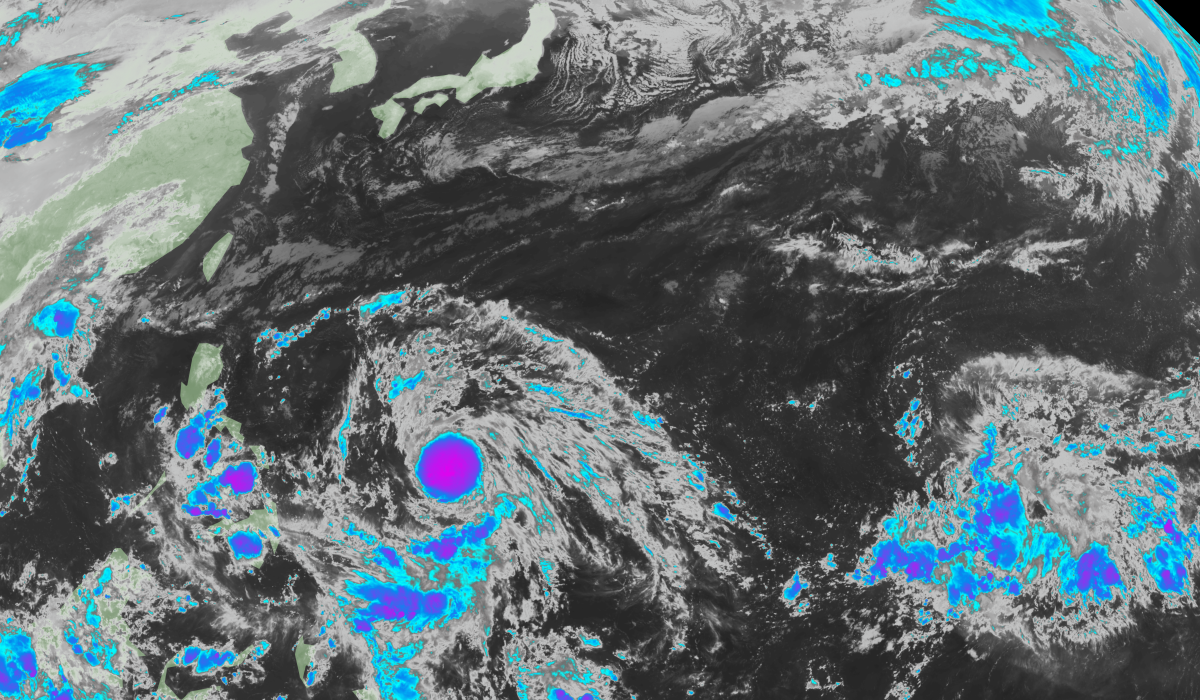

In [5]:
# Crop design cell 

from PIL import Image
f = '/Volumes/SamsungUSB/Himawari_parade/himawari9_b13_20241103_1230.png'
#CROP = (210, 70, 1290, 850) # old size from Irma work
#CROP = (Left, Top, Right, Bottom) # old size from Irma work

CROP = (260, 60, 1400, 1000) # top of planet down, Bay of Bengal east
CROP = (400, 300, 1600, 1000) # UPPER RIGHT LIMB JUST SHOWS & Japan; Borneo LL corner
Image.open(f).crop(CROP)